In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans   #<---- We will use sci-kit learns implementation of K-means
import plotly
plotly.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [57]:
# import scaled dataframe
df = pd.read_csv('../../data/banking_transactions_output_data/scaled_df_v2.csv')
# df = pd.read_csv('scaled_df.csv')
df.head()

,creditSpendtoLimitRatio,averageMonthlySpending,numTnxMonthlyAverage,numAccounts,incomeToSavingsRanking
0,0.500000,0.666667,0.000000,0.000000,0.50
1,0.383667,0.590073,0.216667,1.000000,0.75
2,0.579173,0.666667,0.000000,0.666667,0.25
3,1.000000,0.639782,0.387500,1.000000,0.25
4,0.933909,0.337292,0.450000,1.000000,0.25


# Hierarchical Clustering

In [67]:
# aglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# cluster hierarchy
import scipy.cluster.hierarchy as sch

# silhouette score
from sklearn.metrics import silhouette_score

In [59]:
X = df
# define plot_dendrogram function
def plot_dendrogram(X, method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()
# run the function  

I will try different linkages and select the best one

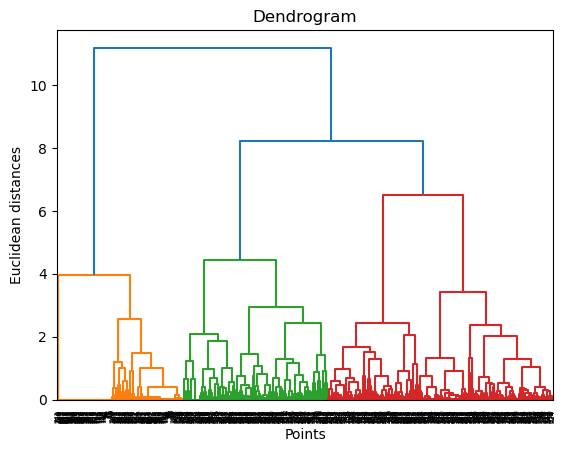

In [60]:
# single
single = AgglomerativeClustering(n_clusters=2, linkage="single")
single_pred = single.fit_predict(X)
plot_dendrogram(X)

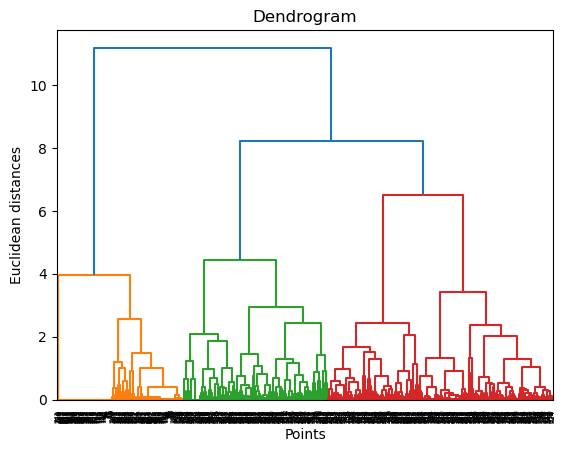

In [61]:
# complete
complete = AgglomerativeClustering(n_clusters=2, linkage="complete")
complete_pred = complete.fit_predict(X)
plot_dendrogram(X)

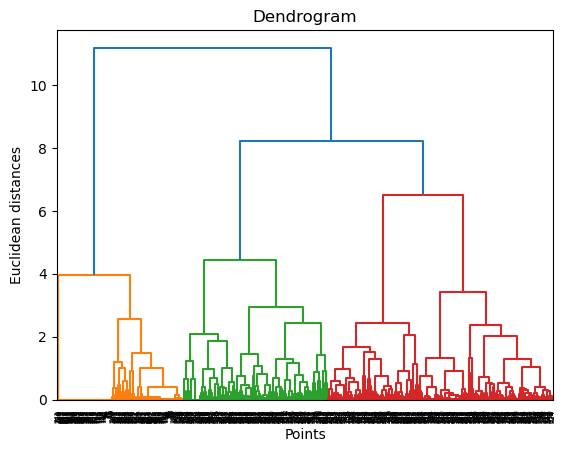

In [64]:
# average
avg = AgglomerativeClustering(n_clusters=2, linkage="average")
avg_pred = avg.fit_predict(X)
plot_dendrogram(X)

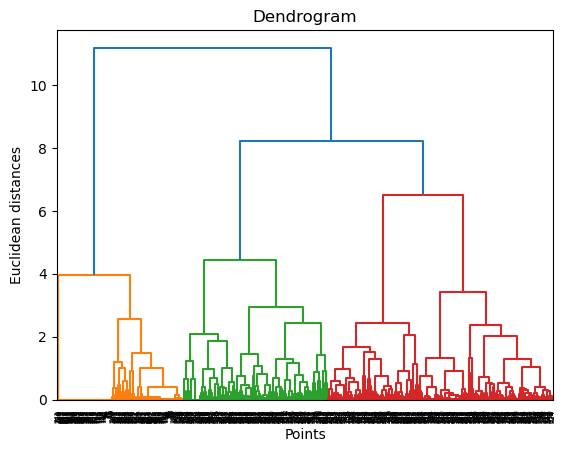

In [65]:
# ward
ward = AgglomerativeClustering(n_clusters=2, linkage="ward")
ward_pred = ward.fit_predict(X)
plot_dendrogram(X)

In [155]:
# Selecting which linkage gives a better silhouette score...
single_silhouette = silhouette_score(X, single_pred)
complete_silhouette = silhouette_score(X, complete_pred)
avg_silhouette = silhouette_score(X, avg_pred)
ward_silhouette = silhouette_score(X, ward_pred)
print( "Scores: \nSingle:", single_silhouette,
      "\nComplete: ", complete_silhouette, 
      "\nAverage: ", avg_silhouette, 
      "\nWard: ", ward_silhouette)

Scores: 
Single: 0.32277937242705385 
Complete:  0.2776777223136297 
Average:  0.3847924537571347 
Ward:  0.4091127697518117


**Ward has the highest score**

**Note**:  These are clearly 4 clusters

In [146]:
# create an object
ac = AgglomerativeClustering(metric='euclidean',
                             linkage='ward',
                             n_clusters = 4) # from K clusters
# fit and predict on the dataframe to get the clsuters
acModel = ac.fit_predict(df)

In [147]:
set(acModel)

{0, 1, 2, 3}

## Visualize with Radial plot

In [148]:
import plotly.graph_objects as go


# find the radians of the clusters by calculating their means

df_with_cluster_labels = df.copy()
df_with_cluster_labels['cluster'] = acModel

cluster_means = []
for c in set(acModel):
    mean = df_with_cluster_labels[df_with_cluster_labels['cluster'] == c].mean()
    mean.drop(labels='cluster', inplace=True)
    cluster_means.append(mean)
cluster_means[0]

creditSpendtoLimitRatio    0.515226
averageMonthlySpending     0.593331
numTnxMonthlyAverage       0.296254
numAccounts                0.848624
incomeToSavingsRanking     0.184633
dtype: float64

In [149]:
list(cluster_means[0].values)
cluster_means[0].index

Index(['creditSpendtoLimitRatio', 'averageMonthlySpending',
       'numTnxMonthlyAverage', 'numAccounts', 'incomeToSavingsRanking'],
      dtype='object')

In [150]:
import plotly.graph_objects as go

for i, cluster in enumerate(cluster_means):
    
    columns = list(cluster.index)
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
          r=list(cluster.values),
          theta=columns,
          fill='toself',
          name='Cluster ' + str(i)
    ))


    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )

    fig.show()

# PCA for visualization

In [151]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
df_pca = pca.fit(df)
df_pca

PCA()

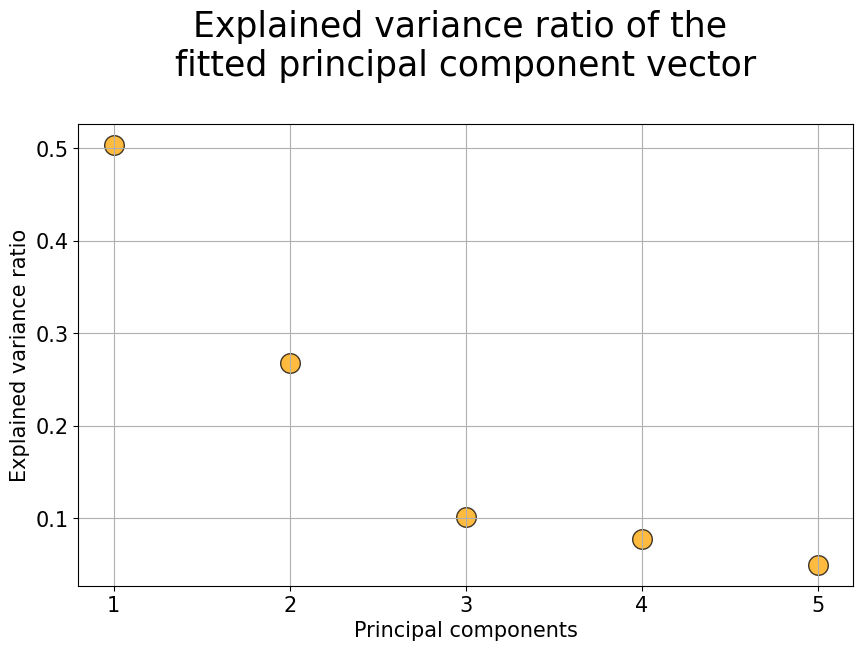

In [152]:
# Expanded variance ratio

plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_pca.explained_variance_ratio_))],
            y=df_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

**Note**: Looks like the first 4 principal components are significant. Well I can only plot a 2D image with the first 2. :()

## Visualizing class separation with PCA

In [153]:
# applying K-clusters method to the PCA 
labels = ac.fit_predict(pca.transform(df))

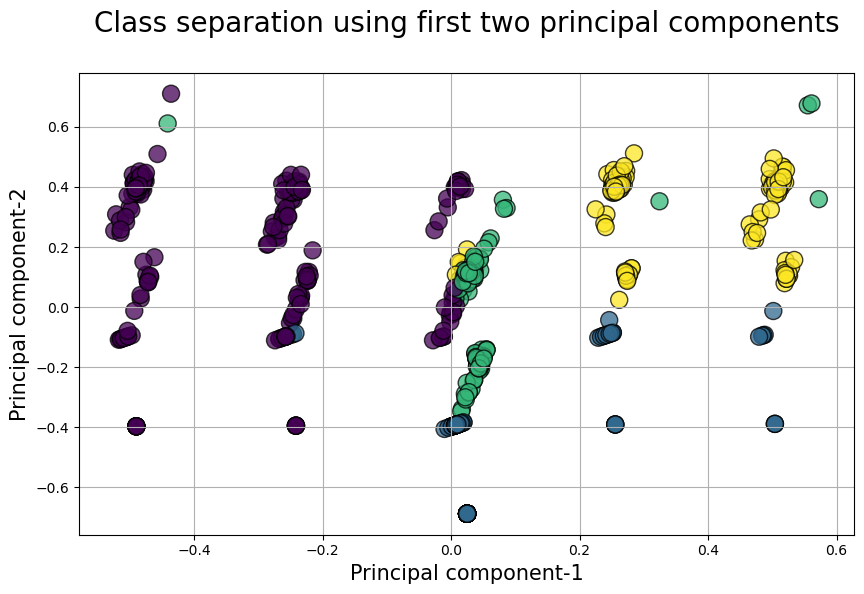

In [154]:
# plot the scatter diagram

df_trans = pca.transform(df)
df_trans = pd.DataFrame(data=df_trans)

plt.figure(figsize=(10,6))
plt.scatter(df_trans[1],df_trans[0],c=labels,edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()
